### Constructing the Molecule

In [16]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="He 0 0 0; H+ 0 0 0.772",
    basis="sto-3g",
    charge=1,
    spin=0,
    
)

problem = driver.run()
print(problem)

### Converting to fermionic operator

In [17]:
fermionic_op = problem.hamiltonian.second_q_op()
#print(fermionic_op)

### Jordan-Wigner Mapping 

In [18]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(fermionic_op)
#print(qubit_jw_op)

### Constructing the Optimization Log

In [19]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

### Chosing the Optimization Method and Variational Form

/tmp/ipykernel_156137/2768004495.py:25: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)


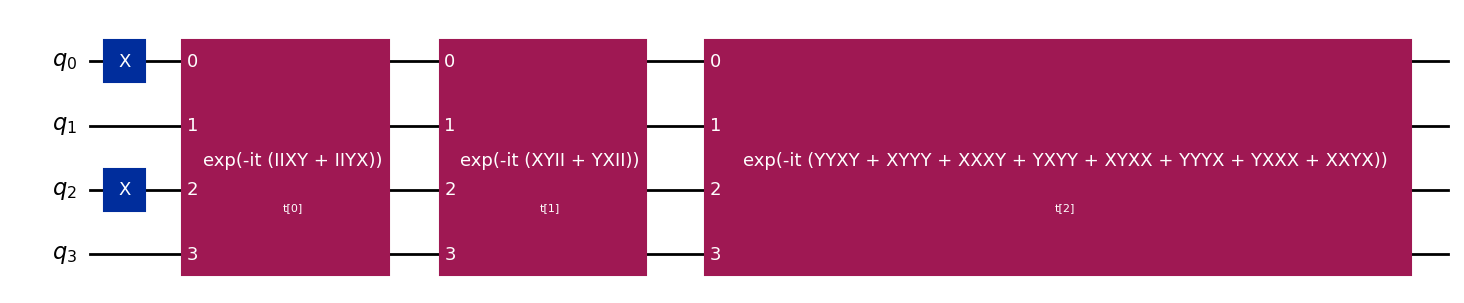

In [20]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP,SPSA,COBYLA, L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
#this is the optimization method
log = OptimizerLog()
# Sequential Least Squares Programming

Optimizer = SLSQP()

# Using Unitary Coupled Cluster as Variational Form and HatreeFock for intial states 
# The Variation Form does affect the number parameters(theta) which also impact the number of iteration and expectation value (ground-state energy)
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)

#Set the initial parameters(theta) as random - this will also affect the convergence of the plot and number of iteration.
#maybe we can a away to appoximate the intial points

vqe_solver.initial_point = np.random.random(ansatz.num_parameters)

ansatz.decompose().draw('mpl')

### Solving the Ground-state energy

In [21]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
#from qiskit_aer import AerSimulator, Aer
calc = GroundStateEigensolver(mapper, vqe_solver)
res = calc.solve(problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4.221949415588
  - computed part:      -4.221949415588
~ Nuclear repulsion energy (Hartree): 1.370925416891
> Total ground state energy (Hartree): -2.851023998697
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.45886857]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.386347815215]
    - computed part:      [0.0  0.0  0.386347815215]
  > Dipole moment (a.u.): [0.0  0.0  1.072520754785]  Total: 1.072520754785
                 (debye): [0.0  0.0  2.726075586203]  Total: 2.726075586203
 


### Ploting the Optimization value over iteration

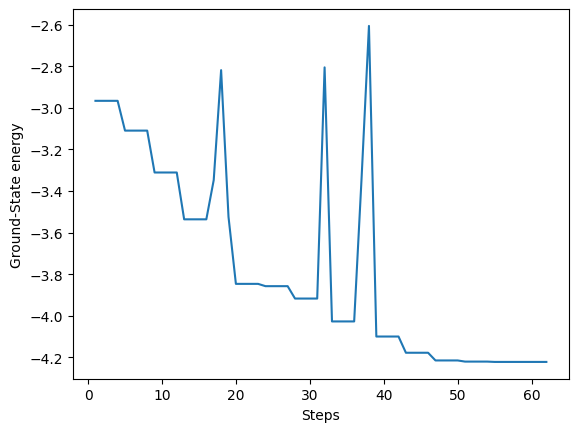

In [22]:
import matplotlib.pyplot as plt

figfig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Ground-State energy')
plt.show()

### Ploting the Paramaters(theta) over iteration

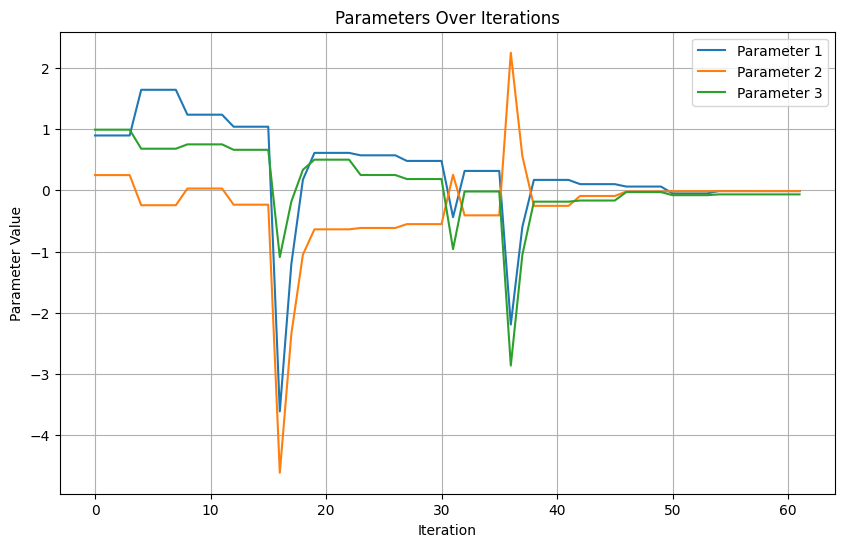

In [23]:
# Extract parameters
data = log.parameters
iterations = range(len(data))
param1 = [row[0] for row in data]
param2 = [row[1] for row in data]
param3 = [row[2] for row in data]

# Plotting the parameters
plt.figure(figsize=(10, 6))

plt.plot(iterations, param1, label='Parameter 1')
plt.plot(iterations, param2, label='Parameter 2')
plt.plot(iterations, param3, label='Parameter 3')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()